## Retail Churn Feature Engineering/Unsupervised Learning RFM Analysis (Recency, Frequency, Monetary)

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
np.set_printoptions(suppress=True)

# Column names that we'll use to read in the data from CSV
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']

# Read data in from CSV as a DataFrame object
churn = pd.read_csv("retail-churn.csv", sep = ",", skiprows = 1, names = col_names)

# Show first 5 rows of DataFrame
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


In [74]:
# Convert timestamp to datetime and overwrite previous column 
churn['timestamp'] = pd.to_datetime(churn['timestamp'])

# Extract date from timestamp column and store in new column churn['date']
churn['date'] = pd.to_datetime(pd.DatetimeIndex(churn['timestamp'], dtype = 'datetime64[ns, UTC]').date)

# Group data by unique rows of user_id and date and obtain quantity and dollar, reset index of aggregated DataFrame
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'}).reset_index()

# Calling rolling function per user_id for dollar, quantity making new DataFrames per feature
dollar_roll_sum_7D = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum().reset_index()

quantity_roll_sum_7D = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum().reset_index()

# Make new feature for last_visit_ndays per user_id over the course of a week
last_visit_ndays = churn_agg.groupby('user_id')['date'].diff(periods = 1)

# Merge quantity, dollar features from above into a new DataFrame on user_id and date
churn_roll = dollar_roll_sum_7D.merge(quantity_roll_sum_7D, on = ['user_id', 'date'])

# Create new column in churn_roll DataFrame for last_visit_ndays feature
churn_roll['last_visit_ndays'] = last_visit_ndays

# Rename columns for dollar and quantity to rolling_sum feature
churn_roll.rename(columns = {'dollar': 'dollar_roll_sum_7D', 'quantity': 'quantity_roll_sum_7D'}, inplace=True)

# Replace all NaT values in last_visit_ndays column as 1000 days (arbitrary value)
churn_roll['last_visit_ndays'].fillna(pd.Timedelta('1000 days'), inplace=True)

# Merge churn_agg and churn_roll on user_id, date to ensure calculations for rolling sum is calculated correctly for 7day window
churn_merged = churn_agg.merge(churn_roll, on = ['user_id', 'date'])

# Convert last_visit_ndays column to int64 # of days
churn_merged['last_visit_ndays'] = churn_merged['last_visit_ndays'].dt.days

In [75]:
# Set number of clusters to 5
n_clusters = 5 

# Designate which features to standardize/fit the model
which_cols = ['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']

# Z-normalize the RFM features 
churn_merged_rescaled = churn_merged[which_cols].apply(lambda x: (x - x.mean()) / x.std(), axis = 0)

# Select data of rescaled features to fit our kmeans
X = churn_merged_rescaled[which_cols]

# Set number of clusters and randomness of clusters for KMeans object 
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)

# Fit
kmeans.fit(X)

# Predict clusters from kmeans and make new column in scaled DataFrame
churn_merged_rescaled['cluster'] = kmeans.predict(X)

c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [76]:
churn_merged_rescaled

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,cluster
0,-0.391981,-0.369906,1.643862,1
1,-0.325514,-0.461485,-0.611911,0
2,-0.024964,-0.186749,-0.641652,0
3,-0.291798,-0.186749,-0.552428,0
4,-0.240743,-0.369906,1.643862,1
...,...,...,...,...
37053,-0.412692,-0.461485,1.643862,1
37054,1.123769,0.454301,1.643862,1
37055,1.810602,1.507455,1.643862,2
37056,0.227420,0.087987,1.643862,1


In [77]:
# Instantiate the Standard Scaler object
zscaler = StandardScaler()

# Fit the zscaler to the non-scaled RFM feature data
zscaler.fit(churn_merged[which_cols])

# Revert cluster centroids to original scale 
zscaler.inverse_transform(kmeans.cluster_centers_)

array([[  829.29879879,     9.88834203,    16.48198344],
       [  936.04426308,    10.2280262 ,   999.99030522],
       [ 4421.55455018,    39.26854907,    74.12779755],
       [35456.92420516,   165.98039309,    56.96794136],
       [19804.14943745,   972.787051  ,     3.6037491 ]])

In [78]:
from sklearn.metrics.pairwise import euclidean_distances
k_vals = range(3, 16)

# Initialize list of k-means ratios. Ratio is = (avg inside distance / avg outside distance)
k_ratios = []

# Initialize list of "Scree" values: Avg Distances.
k_dists = []

k_dists_total = []

for k in k_vals:
    # 1. FIT MODEL FOR K
    print('Computing for k={}'.format(k))
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(churn_merged_rescaled[which_cols])
    
    # 2. Get cluster predictions
    predictions = kmeans.predict(churn_merged_rescaled[which_cols])
    
    # 3. Compute average inside distance to cluster centers
    inside_distances = []
    for center_k in range(k):
        # Get center location
        cluster_center = kmeans.cluster_centers_[center_k]
        # Get set of points belonging to center.
        points_in_cluster = churn_merged_rescaled[which_cols][predictions==center_k]
        # Calculate euclidean distances to centers
        array_of_distances_to_center = euclidean_distances(points_in_cluster, cluster_center.reshape(1, -1))
        # Append to inside distances
        inside_distances.extend(array_of_distances_to_center.tolist())
    
    # 4. Compute Avg Inside cluster distances:
    avg_inside = np.mean(inside_distances)
    total_inside = np.sum(inside_distances)
    # 5. Computer Avg outside cluster distances:
    center_dist_matrix = euclidean_distances(kmeans.cluster_centers_, kmeans.cluster_centers_)
    avg_outside = np.mean(center_dist_matrix[center_dist_matrix > 0])
    
    # 6. Finally, compute ratio:
    k_ratios.append(avg_inside / avg_outside)
    
    # 7. Finally, append to distances:
    k_dists.append(avg_inside)
    k_dists_total.append(total_inside)

print('Done!')

Computing for k=3


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=4


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=5


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=6


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=7


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=8


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=9


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=10


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=11


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=12


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=13


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=14


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Computing for k=15


c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done!


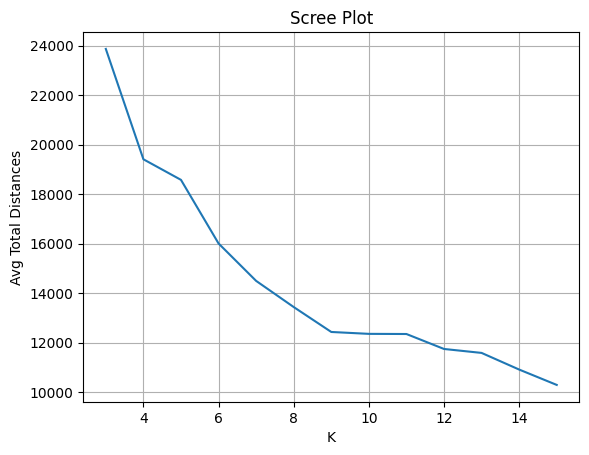

In [79]:
# Plot distance results
k_ratio_graph = sns.lineplot(x=k_vals, y=k_dists_total)
k_ratio_graph.set(xlabel='K', ylabel='Avg Total Distances', title='Scree Plot')
plt.grid()

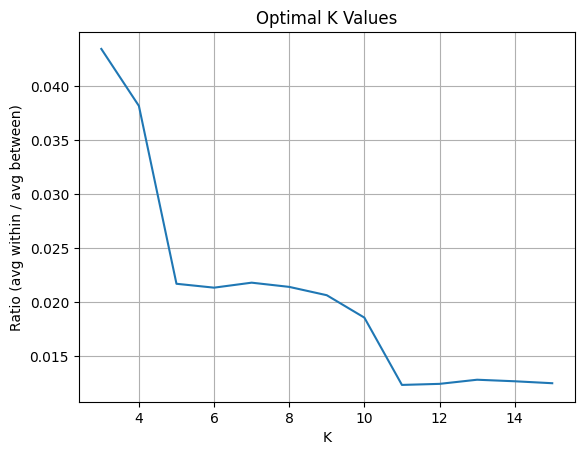

In [80]:
# Plot ratio results!
k_ratio_graph = sns.lineplot(x=k_vals, y=k_ratios)
k_ratio_graph.set(xlabel='K', ylabel='Ratio (avg within / avg between)', title='Optimal K Values')
plt.grid()

**By looking at the scree plot and ratio plot that we have created above, our optimal k values that we can deduce are at k=5 and k=11. We do see additionally significant improvement, from our ratio (avg distance within/avg distance between) from k=11 clusters so this would ideally be a good value to pick for k. This is the k value where no additional margin of ratio decrease is determined by adding additional clustering of the data.** 

In [81]:
# Set number of clusters to 10, value selected above
n_clusters = 11

# Set number of clusters and randomness of clusters for KMeans object 
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)

# Fit
kmeans.fit(X)

# Predict clusters from kmeans and make new column in scaled DataFrame
churn_merged_rescaled['cluster'] = kmeans.predict(X)

c:\Users\james\anaconda3\envs\data\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [82]:
kmeans.cluster_centers_

array([[-0.30614203, -0.27065039,  1.64386171],
       [ 0.15136279,  0.19198302, -0.61218395],
       [15.86028735, 12.95747424, -0.64084474],
       [ 3.12670739,  2.11326432, -0.35787695],
       [ 7.711824  , 40.4538009 , -0.63504299],
       [ 1.04627711,  0.94976752, -0.61594079],
       [ 0.67348389,  0.56483601,  1.64386171],
       [-0.37320752, -0.32260722, -0.60313429],
       [10.02222095,  3.31752008, -0.49263311],
       [28.77314447,  6.3519633 , -0.41195691],
       [20.03862456, 75.36560039, -0.6416522 ]])

In [94]:
# Revert cluster centroids to original scale 
reverted_cluster_centroids = zscaler.inverse_transform(kmeans.cluster_centers_)
cluster_df = pd.DataFrame(reverted_cluster_centroids, columns=which_cols)
cluster_df['k_value'] = range(1,12)
cluster_df['price/item spent'] = cluster_df['dollar_roll_sum_7D']/cluster_df['quantity_roll_sum_7D']

Let's pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features).

In [95]:
clusters = [2, 5, 6]

In [96]:
cluster_df.loc[cluster_df['k_value'].isin(clusters)]

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,k_value,price/item spent
1,1548.086157,17.271136,13.884206,2,89.634297
4,17244.895080,896.543635,3.892634,5,19.234864
5,3406.081167,33.820292,12.242109,6,100.711171


**Cluster A (k-value=2), has a cluster center at ~1500 dollars, quantity of 17 and 13 days since last visit meaning on average they frequently come into the store every two weeks and buy about ~20 items. These seem to be frequent returning customers. Comparing cluster A to cluster C (k-value=6), these customers return as (if not more) frequently than cluster A customers and get twice as many items, spending the same proportional amount per item. They are also frequently returning customers but buy twice as much from the store. Cluster B (k-value = 5) customers are very frequent customers, every 3-4 days. These customers spend roughly 20 dollars more per average on items they buy than do cluster A and cluster C customers but with the more infrequent return of these customers, they are not spending as much throughout the year.** 

In [97]:
cluster_df

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,k_value,price/item spent
0,598.228006,7.167747,999.990305,1,83.461098
1,1548.086157,17.271136,13.884206,2,89.634297
2,34162.496882,296.055005,1.356721,3,115.392398
3,7725.409794,59.229744,125.040505,4,130.431255
4,17244.895080,896.543635,3.892634,5,19.234864
5,3406.081167,33.820292,12.242109,6,100.711171
6,2632.098750,25.413823,999.990305,7,103.569570
7,458.988599,6.033068,17.839764,8,76.078800
8,22041.673793,85.529325,66.139269,9,257.708963
9,60971.793977,151.798128,101.402430,10,401.663674


c:\Users\james\anaconda3\envs\data\lib\site-packages\matplotlib\text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\james\anaconda3\envs\data\lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\james\anaconda3\envs\data\lib\site-packages\matplotlib\text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\james\anaconda3\envs\data\lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[

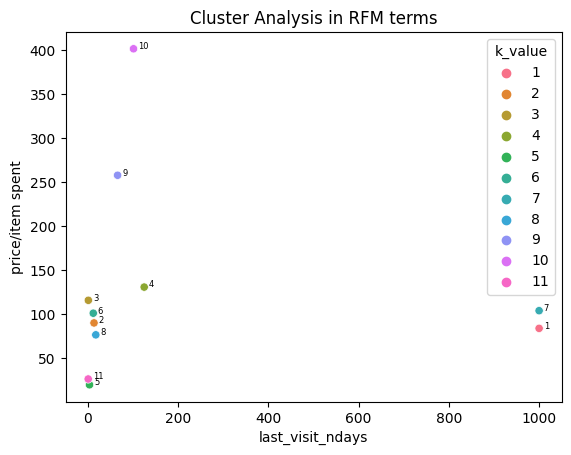

In [120]:
fig, ax = plt.subplots()
ax = sns.scatterplot(cluster_df, x = 'last_visit_ndays', y = 'price/item spent', hue = cluster_df['k_value'].astype('str'))
for i, txt in enumerate(cluster_df['k_value']):
    ax.text(x = cluster_df.loc[cluster_df['k_value']==txt]['last_visit_ndays'] + 10.0, y = cluster_df.loc[cluster_df['k_value']==txt]['price/item spent'], s = txt,fontsize = 6)
plt.title("Cluster Analysis in RFM terms")
plt.show()

**Cluster 1 (return infrequently, spend very little) -recommendation would likely be not to market to this group but possibly coupon expiration dates so they would return more frequently.**

**Cluster 2 (return frequently, spend fairly) -frequency punch card discounts so they come into the store to spend more frequently.**

**Cluster 3 (return frequently, spend fairly) -coupon expiration dates so they would return more frequently.**

**Cluster 4 (return frequently, spend fairly) -frequency punch card discounts so they come into the store to spend more frequently.**

**Cluster 5 (return frequently, low price/item spent--second highest quantity) -Yearly discount if customer purchases certain amount above current expenditure, discuss bulk purchases for items, incentive for bulk purchases instead of everyday purchases.**

**Cluster 6 (return frequently, spend fairly) -coupon expiration dates so they would return more frequently.**

**Cluster 7 (return infrequently, spend very little) -recommendation would likely be not to market to this group but possibly coupon expiration dates so they would return more frequently.**

**Cluster 8 (return frequently, spend fairly) -coupon expiration dates so they would return more frequently, quantity discounts if they purchase certain amount of items.**

**Cluster 9 (return every two months, one of highest price/item spent)-Quantity discounts- Buy more than N items and get percentage off. They purchase, high margin items, discuss with them other inventory with quantity discount.**

**Cluster 10 (return every 100 days, highest price/item spent) Quantity discounts- Buy more than N items and get percentage off. They purchase, high margin items, discuss with them other inventory with quantity discount.**

**Cluster 11 (return everyday, low price/item spent--highest quantity) -Yearly discount if customer purchases certain amount above current expenditure, discuss bulk purchases for items, incentive for bulk purchases instead of everyday purchases.**

### Results and Conclusions.

From performing the k-means clustering of our data, we were able to identify the ideal value of k to be 11 clusters. This was determined by using a scree plot and ratio plot to find where the ratio and avg sum of squares distance showed no proportional decrease in the cluster distances by adding more cluster groups into the data. After evaluating the optimal k-value, we looked within each of these clusters of the k-means model and described which type of customers that each of these groups are belonging to frequent customers (clusters 2, 3, 5, 6, 8, 11), high quantity purchasers (cluster 3, 5, 11), highest spenders (clusters 3, 10, 11). Finally, based on these cluster descriptions, we proprosed how a marketing could use coupons to increase each groups RFM values.   

### Citations

1. 2022-April, Nick McClure, Lesson 8 presentation from DS510 in UW-PCE class.
2. https://pandas.pydata.org/docs/index.html